In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    ExponentialScatteringModel,
    pspec_numba,
)

%matplotlib notebook

In [2]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


<IPython.core.display.Javascript object>


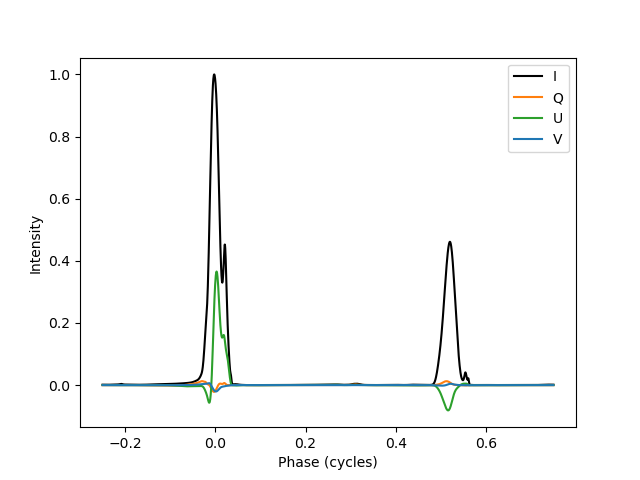

In [3]:
template.plot(what='IQUV', shift=0.25)
plt.show()

In [4]:
pulse_freq = 641.948222127829 # Hz
bandwidth = 1.5625e6 # Hz
model = BasebandModel(template, bandwidth=bandwidth, pulse_freq=pulse_freq)
predictor = FreqOnlyPredictor(pulse_freq)

In [5]:
data = model.sample(2**24)

In [6]:
pspec = pspec_numba(data, 128, 256, predictor)

<IPython.core.display.Javascript object>


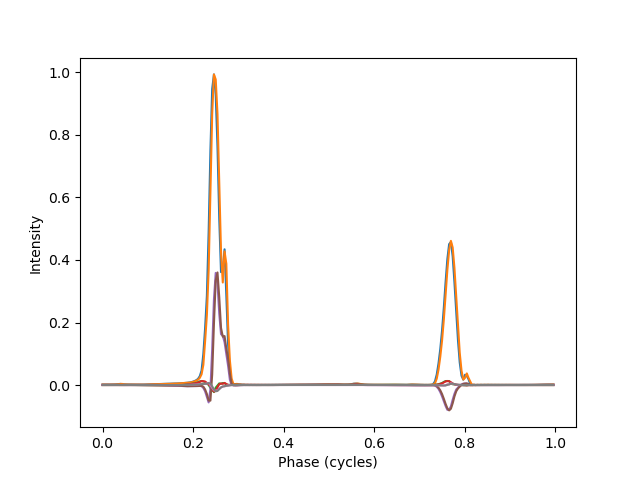

In [7]:
plt.plot(pspec.phase, np.roll(np.mean(pspec.I, axis=0), 256//4))
plt.plot(pspec.phase, np.roll(template.resample(256).I, 256//4))
plt.plot(pspec.phase, np.roll(np.mean(pspec.Q, axis=0), 256//4))
plt.plot(pspec.phase, np.roll(template.resample(256).Q, 256//4))
plt.plot(pspec.phase, np.roll(np.mean(pspec.U, axis=0), 256//4))
plt.plot(pspec.phase, np.roll(template.resample(256).U, 256//4))
plt.plot(pspec.phase, np.roll(np.mean(pspec.V, axis=0), 256//4))
plt.plot(pspec.phase, np.roll(template.resample(256).V, 256//4))
plt.xlabel("Phase (cycles)")
plt.ylabel("Intensity")
plt.show()

<IPython.core.display.Javascript object>


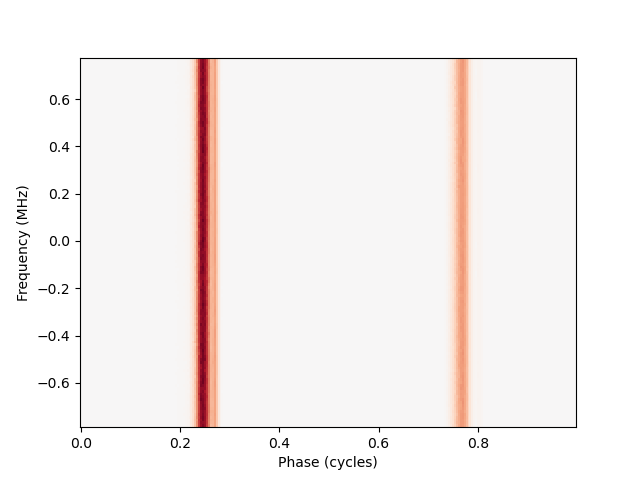

In [8]:
pspec.plot(what='I', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.show()

<IPython.core.display.Javascript object>


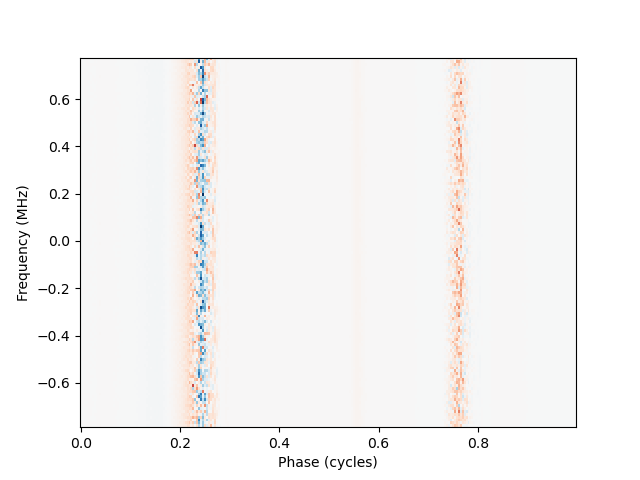

In [9]:
pspec.plot(what='Q', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.show()

<IPython.core.display.Javascript object>


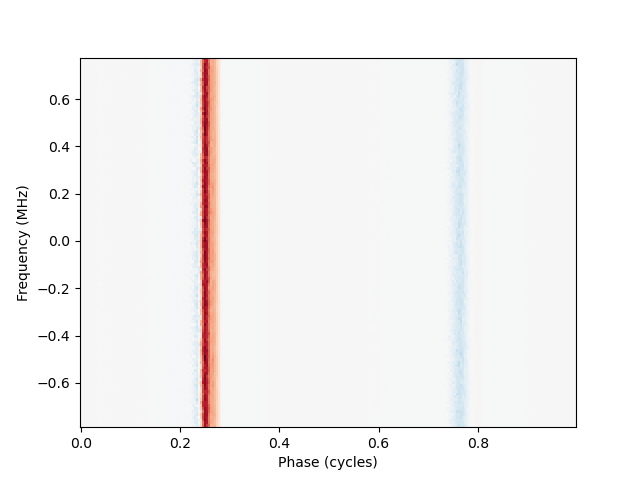

In [10]:
pspec.plot(what='U', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.show()

<IPython.core.display.Javascript object>


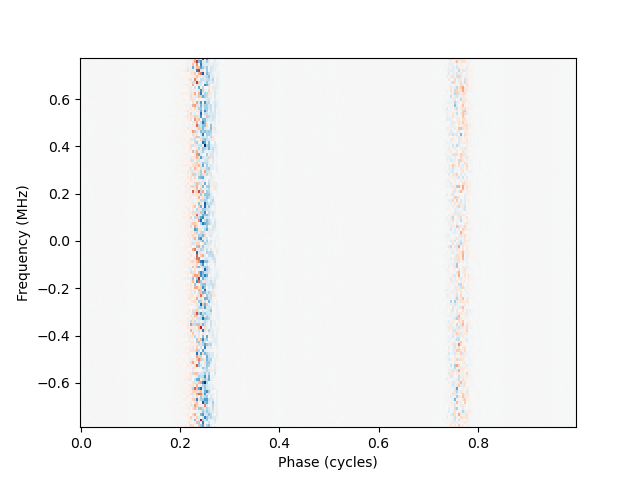

In [11]:
pspec.plot(what='V', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.show()

In [12]:
model = BasebandModel(template, bandwidth=bandwidth, pulse_freq=pulse_freq, feed_poln='CIRC')
data_circ = model.sample(2**24)

In [13]:
pspec_circ = pspec_numba(data_circ, 128, 256, predictor)

<IPython.core.display.Javascript object>


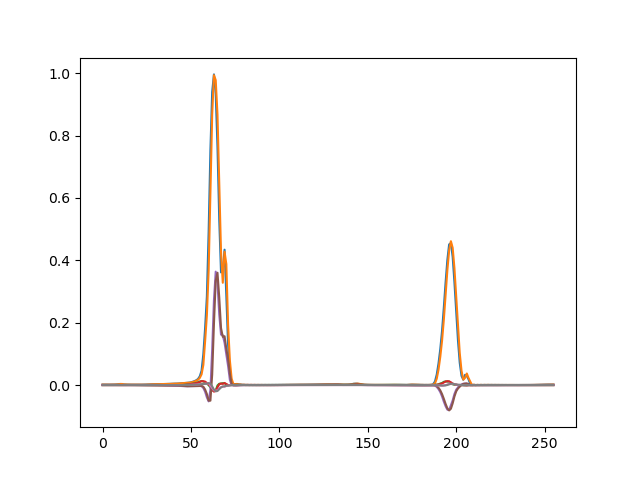

In [14]:
plt.plot(np.roll(np.mean(pspec_circ.I, axis=0), 256//4))
plt.plot(np.roll(template.resample(256).I, 256//4))
plt.plot(np.roll(np.mean(pspec_circ.Q, axis=0), 256//4))
plt.plot(np.roll(template.resample(256).Q, 256//4))
plt.plot(np.roll(np.mean(pspec_circ.U, axis=0), 256//4))
plt.plot(np.roll(template.resample(256).U, 256//4))
plt.plot(np.roll(np.mean(pspec_circ.V, axis=0), 256//4))
plt.plot(np.roll(template.resample(256).V, 256//4))

In [17]:
data.A.nbytes/2**20

256.0

In [18]:
data.t

array([0.00000000e+00, 6.40000000e-07, 1.28000000e-06, ...,
       1.07374163e+01, 1.07374170e+01, 1.07374176e+01])